# NLP Classifier questions

The aim of this is a binary classifier. Given an unseen set of statements and correctly decipher if they are movie questions or stackoverflow posts

## Libraries

### Colaboratory Specific Code

This mounts your Google Drive folder so you can access it from Colaboratory

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

We also want to change the working directory so that the file references work. Here I've places the files for this class inside a folder called 'class_1' that itself is inside a folder called 'NLP_class'.

In [6]:
# %cd drive/My\ Drive/NLP_class/0719_question
# !ls

In [7]:
# !pip install scikit-plot

### Dependencies

In [8]:
import pandas as pd
from sklearn.utils import shuffle
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    plot_confusion_matrix(y, preds)

## Pre-process the data

This code cleans the text

In [10]:
# There is a problem with this codes as it is possible for all words to be removed leaving a null value
# This is solved in line 25 with the if statement

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " " + text + " "
    for sw in STOPWORDS:
        text = text.replace(" "+sw+" ", " ") # delete stopwords from text
    text = re.sub('[ ][ ]+', " ", text)

    #     print("text:", text)
#     print(len(text))
    
    if len(text) > 1: # only run if there are words present
      if text[0] == ' ':
          text = text[1:]
      if text[-1] == ' ':
          text = text[:-1]
        
    return text

### Inspect Data
Let's see what the data looks like

In [11]:
dialogues = pd.read_csv('dialogues.tsv', sep='\t')
tagged = pd.read_csv('tagged_posts.tsv', sep='\t')

In [12]:
dialogues.head(2)

,text,tag
0,Okay -- you're gonna need to learn how to lie.,dialogue
1,I'm kidding. You know how sometimes you just ...,dialogue


In [13]:
tagged.head(2)

,post_id,title,tag
0,9,Calculate age in C#,c#
1,16,Filling a DataSet or DataTable from a LINQ que...,c#


# Movie or StackOverflow?

### Create base dataset

Now we can drop the 'tag' columns of both and assign new labels. 

We set a movie question to label 0 and a stack overflow post to label 1

We also need to drop the 'post_id' column of the stack overflow data and rename 'title' to 'text'

In [14]:
movie = dialogues.drop(columns=['tag'])
movie['label'] = int(0)
movie.head(2)

,text,label
0,Okay -- you're gonna need to learn how to lie.,0
1,I'm kidding. You know how sometimes you just ...,0


In [15]:
stack = tagged.drop(columns=['post_id','tag'])
stack['label'] = int(1)
stack = stack.rename(columns={"title": "text"})
stack.head(2)

,text,label
0,Calculate age in C#,1
1,Filling a DataSet or DataTable from a LINQ que...,1


We now combine the two different data sets into one single data set.

In [16]:
data = movie.append(stack, ignore_index=True)
data.head()

,text,label
0,Okay -- you're gonna need to learn how to lie.,0
1,I'm kidding. You know how sometimes you just ...,0
2,Like my fear of wearing pastels?,0
3,I figured you'd get to the good stuff eventually.,0
4,Thank God! If I had to hear one more story ab...,0


### Clean the text

In [17]:
data.shape

(615477, 2)

Here we can see that certain lines are entirely made up of stopwords and symbols. We need to account for this.

In [18]:
print("This line: ", data.loc[82457, 'text'])
print("\nBecomes: ", text_prepare(data.loc[82457, 'text']))

This line:  Do you have to do that?

Becomes:   


Now we run the cleaning function on the whole database.

In [19]:
%time cleaned_text = [text_prepare(x) for x in data['text']]

Wall time: 32.8 s


In [20]:
clean_text = pd.DataFrame({'clean_data': cleaned_text})
clean_text.head()

,clean_data
0,okay youre gonna need learn lie
1,im kidding know sometimes become persona dont ...
2,like fear wearing pastels
3,figured youd get good stuff eventually
4,thank god hear one story coiffure


In [21]:
clean = pd.concat([clean_text, data], axis = 1, ignore_index=True)
clean = shuffle(clean)
clean.head()

,0,1,2
378098,syntax error insert statement c# oledb,Syntax error in INSERT INTO statement in c# ol...,1
274212,applying methods object private variables java...,applying methods to object and private variabl...,1
527013,xampp openssl errors calling openssl_pkey_new,xampp openssl errors when calling openssl_pkey...,1
25072,let buyer beware,Let the buyer beware.,0
491370,read write locking confusion,Read/Write locking confusion,1


In [22]:
clean = clean.drop(columns=[1])
clean.head(20)

,0,2
378098,syntax error insert statement c# oledb,1
274212,applying methods object private variables java...,1
527013,xampp openssl errors calling openssl_pkey_new,1
25072,let buyer beware,0
491370,read write locking confusion,1
176289,im alright,0
323152,get last segment regular expression,1
588685,wcf service completely locked,1
102626,ask theres nothing new coke,0
380088,complex example project java desktopstyle gui,1


Check that there are only 2 labels (binary) and see the amount of each.

In [23]:
unique_labels = clean.groupby(2).nunique()
unique_labels.head()

,0,2
2,,
0,206927,1
1,394521,1


### Train Test Validation Split

In [24]:
clean_data = clean[0]
clean_data.head()

378098               syntax error insert statement c# oledb
274212    applying methods object private variables java...
527013        xampp openssl errors calling openssl_pkey_new
25072                                      let buyer beware
491370                         read write locking confusion
Name: 0, dtype: object

In [25]:
clean_labels = clean[2]
clean_labels.head()

378098    1
274212    1
527013    1
25072     0
491370    1
Name: 2, dtype: int64

First we split off the validation set as 20% of the overall data set.

In [26]:
df_data, X_val, df_labels, y_val = train_test_split(
    clean_data, clean_labels, test_size=0.2, random_state=42, shuffle=False)

Then we split the remaining into training and test data.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.25,
                                                        random_state=42,
                                                        shuffle=False)

The end result is 60% training data, 20% test data and 20% validation data

In [28]:
print("Shape of X_train", X_train.shape)
print("Shape of y_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Shape of X_val", X_val.shape)
print("Shape of y_val", y_val.shape)

Shape of X_train (369285,)
Shape of y_train (369285,)
Shape of X_test (123096,)
Shape of y_test (123096,)
Shape of X_val (123096,)
Shape of y_val (123096,)


### Apply TF-IDF Weighting

We first need to learn the words for the dictionary from our training data.

In [29]:
vectorizer = TfidfVectorizer(norm=u'l1', token_pattern='(\S+)', min_df=5, max_df=0.9, ngram_range=(1,2))

%time vectorizer.fit_transform(X_train)
# print(vectorizer.get_feature_names(10))

Wall time: 8.52 s


<369285x65387 sparse matrix of type '<class 'numpy.float64'>'
	with 2693725 stored elements in Compressed Sparse Row format>

Apply this learned TF-IDF transform to our different dataframes

In [30]:
%time train_tf = vectorizer.transform(X_train)
# train_tf = csr_matrix.mean(train_tf, axis=0)

%time test_tf = vectorizer.transform(X_test)
# test_tf = csr_matrix.mean(test_tf, axis=0)

%time val_tf = vectorizer.transform(X_val)
# val_tf = csr_matrix.mean(val_tf, axis=0)


Wall time: 4.05 s
Wall time: 1.38 s
Wall time: 1.37 s


We can see that the different dataframes have been transformed intt Compressed Sparse Row format data. This is very important as sparsity has a big impact on accuracy.

In [31]:
print("Shape of train_tf", train_tf.shape)

print("Shape of test_tf", test_tf.shape)

print("Shape of val_tf", val_tf.shape)

Shape of train_tf (369285, 65387)
Shape of test_tf (123096, 65387)
Shape of val_tf (123096, 65387)


## Classify CSR

First we will attempt to classify the full CSR dataset

### Naive Bayes
Interestingly this crashes and causes the runtime to reset as the dimensionality is too high.

In [32]:
# nb = GaussianNB()
# nb.fit(train_tf.todense(), y_train.astype(int))

In [33]:
# nb_score_test = nb.score(test_tf.todense(), y_test.astype(int))
# nb_score_test

### Linear Regression

In [34]:
linr = linear_model.LinearRegression(n_jobs = -1)
%time linr.fit(train_tf, y_train.astype(int))

Wall time: 40.1 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [35]:
%time linr_score_test = linr.score(test_tf, y_test.astype(int))
print(linr_score_test*100)

Wall time: 6.54 ms
92.39921614027921


We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [36]:
lr = linear_model.LogisticRegression(C=10.0, penalty='l2', solver = 'newton-cg', n_jobs=-1)
%time lr.fit(train_tf, y_train)

Wall time: 6.65 s


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
%time lr_score_test = lr.score(test_tf, y_test.astype(int))
print(lr_score_test*100)

Wall time: 17 ms
98.84480405537141


We can better understand the accuracy by looking at a confusion matrix




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Log loss: 0.07106569802648728
Accuracy: 0.9843861701436277


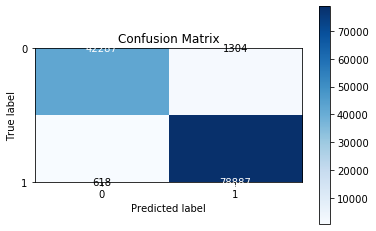

In [38]:
evaluate_features(test_tf, y_test, lr)

### Support Vector Machine
The high dimensionality means that this takes a ridiculous amount of time to run.

In [39]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf.fit(train_tf, y_train.astype(int))

In [40]:
# %time clf_score = clf.score(test_tf, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score)

### Random Forest
The high dimensionality means that this takes a ridiculous amount of time to run.

In [41]:
rf = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

%time rf.fit(train_tf, y_train.astype(int))

Wall time: 1min 5s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [42]:
%time rf_score = rf.score(test_tf, y_test.astype(int))
print("RF accuracy on test:\t %f" % rf_score)

Wall time: 551 ms
RF accuracy on test:	 0.752713


We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.8min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


Log loss: 0.5383024696643143
Accuracy: 0.7524614934685124


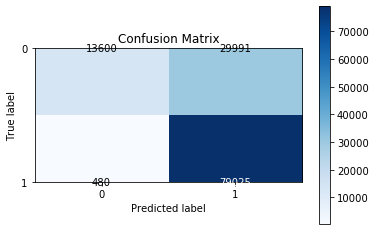

In [43]:
evaluate_features(test_tf, y_test, rf)

We could use a gridsearch to find optimal paramters for a classifier

In [44]:
# rf_grid = RandomForestClassifier(random_state=42)

# param_grid = { 
#     'n_estimators': [100, 120, 140, 160, 180, 200, 220, 240, 260],
#     'min_samples_leaf': [3, 5, 7],
#     'min_samples_split': [2, 3, 4, 5, 6],
#     'max_depth' : [5, 10, 15, 20, 25, 30, 35, 40, 45],
#     'criterion' :['gini', 'entropy']
# }


# CV_rf = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv= 5, n_jobs = -1, 
#                      verbose = 2)
# CV_rf.fit(train_tf, y_train.astype(int))
# CV_rf.best_params_

## Scores on CSR Validation Set

In [45]:
# nb_score_val = nb.score(val_tf.todense(), y_val.astype(int))
# nb_score_val

In [46]:
linr_score_val = linr.score(val_tf, y_val.astype(int))
linr_score_val

0.9261901321174083

In [47]:
lr_score_val = lr.score(val_tf, y_val.astype(int))
lr_score_val

0.989000454929486

In [48]:
# clf_score_val = clf.score(X_val, y_val.astype(int))
# clf_score_val

In [49]:
rf_score_val = rf.score(val_tf, y_val.astype(int))
rf_score_val

0.7532576200688893

## Classify Reduced
We will now reduce the dimensionality of the dataset and rety classification.

### Reduce Dimensions using SVD

In [50]:
NUM_DIMEN = 50
svd = TruncatedSVD(n_components=NUM_DIMEN)

In [51]:
%time train_sv = svd.fit_transform(train_tf)
var = svd.explained_variance_.sum() * 100
print("Training data variance with %d SVD components is %f" % (NUM_DIMEN, var))

Wall time: 8.79 s
Training data variance with 50 SVD components is 1.630023


In [52]:
%time test_sv = svd.fit_transform(test_tf)
%time val_sv = svd.fit_transform(val_tf)

Wall time: 3.36 s
Wall time: 3.43 s


In [53]:
print("Shape of train_sv", train_sv.shape)

print("Shape of test_sv", test_sv.shape)

print("Shape of val_sv", val_sv.shape)

Shape of train_sv (369285, 50)
Shape of test_sv (123096, 50)
Shape of val_sv (123096, 50)


### Naive Bayes
With the reduced dimensionality we can use a Naive Bayes classifier

In [54]:
nb_sv = GaussianNB()
%time nb_sv.fit(train_sv, y_train.astype(int))

Wall time: 449 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [55]:
%time nb_score_test_sv = nb_sv.score(test_sv, y_test.astype(int))
nb_score_test_sv*100

Wall time: 170 ms


45.11032040033795

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Log loss: 1.9138352948399748
Accuracy: 0.8116266978618314


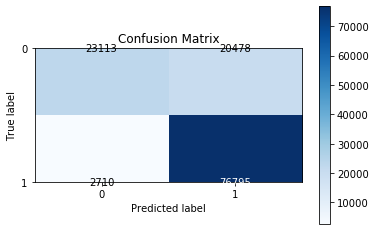

In [56]:
evaluate_features(test_sv, y_test, nb_sv)

### Linear Regression

In [57]:
linr_sv = linear_model.LinearRegression(n_jobs = -1)
%time linr_sv.fit(train_sv, y_train.astype(int))

Wall time: 747 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [58]:
%time linr_score_test_sv = linr_sv.score(test_sv, y_test.astype(int))
linr_score_test_sv*100

Wall time: 17 ms


-98.797477943136

We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [59]:
lr_sv = linear_model.LogisticRegression(C=1.0, penalty='l2', solver = 'newton-cg', n_jobs=-1)
%time lr_sv.fit(train_sv, y_train)

Wall time: 16.4 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
%time lr_score_test_sv = lr_sv.score(test_sv, y_test.astype(int))
lr_score_test_sv*100

Wall time: 24 ms


24.59543770715539

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Log loss: 0.25330340647212024
Accuracy: 0.9209478780788978


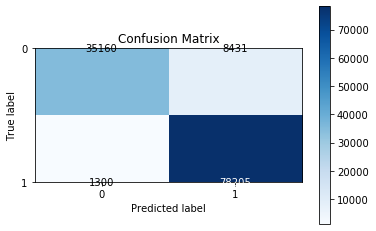

In [61]:
evaluate_features(test_sv, y_test, lr_sv)

### Support Vector Machine
Even at low dimension this takes a lot of time to run.

In [62]:
# clf_sv = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf_sv.fit(train_sv, y_train.astype(int))

In [63]:
# %time clf_score_sv = clf_sv.score(test_sv, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score_sv)

### Random Forest

In [64]:
rf_sv = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

%time rf_sv.fit(train_sv, y_train.astype(int))

Wall time: 2min 20s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [65]:
%time rf_score_sv = rf_sv.score(test_sv, y_test.astype(int))
print("RF accuracy on test:\t %f" % rf_score_sv)

Wall time: 546 ms
RF accuracy on test:	 0.183832


We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.4min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


Log loss: 0.10854642171538983
Accuracy: 0.9636137648664457


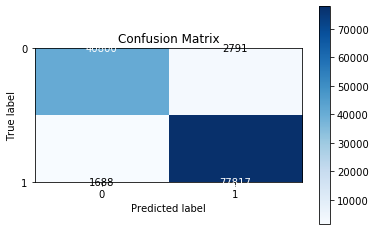

In [66]:
evaluate_features(test_sv, y_test, rf_sv)

# Which Programming Language?

### Clean the Text and Assign Labels

First we load in the StackOverflow dataset and drop the unused post_id column

In [67]:
tagged.head()

,post_id,title,tag
0,9,Calculate age in C#,c#
1,16,Filling a DataSet or DataTable from a LINQ que...,c#
2,39,Reliable timer in a console application,c#
3,42,Best way to allow plugins for a PHP application,php
4,59,"How do I get a distinct, ordered list of names...",c#


In [68]:
stackover = tagged.drop(columns=['post_id'])
stackover.head()

,title,tag
0,Calculate age in C#,c#
1,Filling a DataSet or DataTable from a LINQ que...,c#
2,Reliable timer in a console application,c#
3,Best way to allow plugins for a PHP application,php
4,"How do I get a distinct, ordered list of names...",c#


In [69]:
relevant_stack = [text_prepare(x) for x in stackover['title']]
clean_titles = pd.DataFrame({'clean_data': relevant_stack})
clean_titles.head()

,clean_data
0,calculate age c#
1,filling dataset datatable linq query result set
2,reliable timer console application
3,best way allow plugins php application
4,get distinct ordered list names datatable usin...


In [70]:
clean_stack = pd.concat([clean_titles, stackover], axis = 1, ignore_index=True)
clean_stack = shuffle(clean_stack)
clean_stack.head()

,0,1,2
254350,logging facebook without browser,Logging into Facebook without a Browser,python
70326,split ienumerablestring groups ienumerablestring,How can I split an IEnumerable<String> into gr...,c#
138029,disable back button gwt,Disable back button in GWT,java
318638,dynamic realloc global variable c,How to dynamic realloc a global variable with C,c_cpp
118314,extracting 1 hyperlinks paragraph text javascr...,Extracting 1 or more hyperlinks from paragraph...,javascript


In [71]:
clean_stack = clean_stack.drop(columns=[1])
clean_stack.head(15)

,0,2
254350,logging facebook without browser,python
70326,split ienumerablestring groups ienumerablestring,c#
138029,disable back button gwt,java
318638,dynamic realloc global variable c,c_cpp
118314,extracting 1 hyperlinks paragraph text javascr...,javascript
133742,using gdb external libs,c_cpp
102915,java socket tcp maximum segment size,java
278820,output multiline html variable interpolation u...,javascript
20320,javaawtheadlessexception applet displayed part 2,java
184116,make jquery slidetoggle effect multiple div page,javascript


Check how many unique labels we have

In [72]:
unique_languages = clean_stack.groupby(2).nunique()
unique_languages.head(15)

,0,2
2,,
c#,93829,1
c_cpp,63917,1
java,63149,1
javascript,49696,1
php,56746,1
python,33262,1
r,2390,1
ruby,23573,1
swift,3,1


Now we convert these categorical labels into numericals ones

In [73]:
clean_stack[2] = clean_stack[2].astype('category')
clean_stack["label"] = clean_stack[2].cat.codes
clean_stack.head(10)

,0,2,label
254350,logging facebook without browser,python,5
70326,split ienumerablestring groups ienumerablestring,c#,0
138029,disable back button gwt,java,2
318638,dynamic realloc global variable c,c_cpp,1
118314,extracting 1 hyperlinks paragraph text javascr...,javascript,3
133742,using gdb external libs,c_cpp,1
102915,java socket tcp maximum segment size,java,2
278820,output multiline html variable interpolation u...,javascript,3
20320,javaawtheadlessexception applet displayed part 2,java,2
184116,make jquery slidetoggle effect multiple div page,javascript,3


In [74]:
clean_stack = clean_stack.drop(columns=[2])
clean_stack.head()

,0,label
254350,logging facebook without browser,5
70326,split ienumerablestring groups ienumerablestring,0
138029,disable back button gwt,2
318638,dynamic realloc global variable c,1
118314,extracting 1 hyperlinks paragraph text javascr...,3


### Train Test Validation Split

In [75]:
stack_data = clean_stack[0]
stack_data.head()

254350                     logging facebook without browser
70326      split ienumerablestring groups ienumerablestring
138029                              disable back button gwt
318638                    dynamic realloc global variable c
118314    extracting 1 hyperlinks paragraph text javascr...
Name: 0, dtype: object

In [76]:
stack_labels = clean_stack['label']
stack_labels.head()

254350    5
70326     0
138029    2
318638    1
118314    3
Name: label, dtype: int8

First we split off the validation set as 20% of the overall data set.

In [77]:
df_data, X_val, df_labels, y_val = train_test_split(
    stack_data, stack_labels, test_size=0.2, random_state=42, shuffle=False)

Then we split the remaining into training and test data.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.25,
                                                        random_state=42,
                                                        shuffle=False)

The end result is 60% training data, 20% test data and 20% validation data

In [79]:
print("Shape of X_train", X_train.shape)
print("Shape of y_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Shape of X_val", X_val.shape)
print("Shape of y_val", y_val.shape)

Shape of X_train (238120,)
Shape of y_train (238120,)
Shape of X_test (79374,)
Shape of y_test (79374,)
Shape of X_val (79374,)
Shape of y_val (79374,)


### Apply TF-IDF Weighting

We first need to learn the words for the dictionary from our training data.

In [80]:
vectorizer = TfidfVectorizer(norm=u'l1', token_pattern='(\S+)', min_df=5, max_df=0.9, ngram_range=(1,2))

%time vectorizer.fit_transform(X_train)
# print(vectorizer.get_feature_names(10))

Wall time: 4.32 s


<238120x39305 sparse matrix of type '<class 'numpy.float64'>'
	with 1641280 stored elements in Compressed Sparse Row format>

Apply this learned TF-IDF transform to our different dataframes

In [81]:
%time train_tf = vectorizer.transform(X_train)
# train_tf = csr_matrix.mean(train_tf, axis=0)

%time test_tf = vectorizer.transform(X_test)
# test_tf = csr_matrix.mean(test_tf, axis=0)

%time val_tf = vectorizer.transform(X_val)
# val_tf = csr_matrix.mean(val_tf, axis=0)


Wall time: 2.48 s
Wall time: 795 ms
Wall time: 794 ms


We can see that the different dataframes have been transformed intt Compressed Sparse Row format data. This is very important as sparsity has a big impact on accuracy.

In [82]:
print("Shape of train_tf", train_tf.shape)

print("Shape of test_tf", test_tf.shape)

print("Shape of val_tf", val_tf.shape)

Shape of train_tf (238120, 39305)
Shape of test_tf (79374, 39305)
Shape of val_tf (79374, 39305)


## Classify CSR

First we will attempt to classify the full CSR dataset

### Naive Bayes
Interestingly this crashes and causes the runtime to reset as the dimensionality is too high.

In [83]:
# nb = GaussianNB()
# nb.fit(train_tf.todense(), y_train.astype(int))

In [84]:
# nb_score_test = nb.score(test_tf.todense(), y_test.astype(int))
# nb_score_test

### Linear Regression

In [85]:
linr = linear_model.LinearRegression(n_jobs = -1)
%time linr.fit(train_tf, y_train.astype(int))

Wall time: 9.57 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [86]:
%time linr_score_test = linr.score(test_tf, y_test.astype(int))
linr_score_test*100

Wall time: 4 ms


43.874063134696264

### Logistic Regression
This is automatically a mult-class classifier. Effectively a One vs Rest LR

In [87]:
# lr = linear_model.LogisticRegression(C=1.0, penalty='l2', solver = 'saga', n_jobs=-1)
lr = linear_model.LogisticRegression(solver='newton-cg',C=5, penalty='l2',n_jobs=-1)

%time lr.fit(train_tf, y_train)

C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 8.28 s


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [88]:
%time lr_score_test = lr.score(test_tf, y_test.astype(int))
lr_score_test*100

Wall time: 23 ms


80.47975407564189

### Support Vector Machine
The high dimensionality means that this takes a ridiculous amount of time to run.

In [89]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf.fit(train_tf, y_train.astype(int))

In [90]:
# %time clf_score = clf.score(test_tf, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score)

### Random Forest
The high dimensionality means that this takes a ridiculous amount of time to run.

In [91]:
rf = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

%time rf.fit(train_tf, y_train.astype(int))

Wall time: 39.7 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [92]:
%time rf_score = rf.score(test_tf, y_test.astype(int))
print("RF accuracy on test:\t %f" % rf_score)

Wall time: 753 ms
RF accuracy on test:	 0.495477


We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Log loss: 1.3957007127641845
Accuracy: 0.4953889182855847


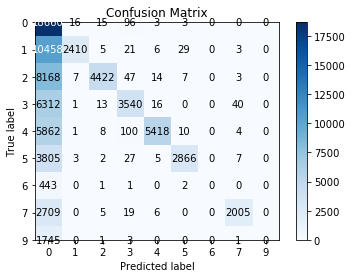

In [115]:
evaluate_features(test_tf, y_test, rf)

## Scores on CSR Validation Set

In [93]:
# nb_score_val = nb.score(val_tf.todense(), y_val.astype(int))
# nb_score_val

In [94]:
linr_score_val = linr.score(val_tf, y_val.astype(int))
linr_score_val

0.4461625857690663

In [95]:
lr_score_val = lr.score(val_tf, y_val.astype(int))
lr_score_val

0.80765741930607

In [96]:
# clf_score_val = clf.score(X_val, y_val.astype(int))
# clf_score_val

In [97]:
rf_score_val = rf.score(val_tf, y_val.astype(int))
rf_score_val

0.49909290195781997

## Classify Reduced
We will now reduce the dimensionality of the dataset and rety classification.

### Reduce Dimensions using SVD

In [98]:
NUM_DIMEN = 50
svd = TruncatedSVD(n_components=NUM_DIMEN)

In [99]:
%time train_sv = svd.fit_transform(train_tf)
var = svd.explained_variance_.sum() * 100
print("Training data variance with %d SVD components is %f" % (NUM_DIMEN, var))

Wall time: 5.47 s
Training data variance with 50 SVD components is 1.735426


In [100]:
%time test_sv = svd.fit_transform(test_tf)
%time val_sv = svd.fit_transform(val_tf)

Wall time: 2.05 s
Wall time: 2.14 s


In [101]:
print("Shape of train_sv", train_sv.shape)

print("Shape of test_sv", test_sv.shape)

print("Shape of val_sv", val_sv.shape)

Shape of train_sv (238120, 50)
Shape of test_sv (79374, 50)
Shape of val_sv (79374, 50)


### Naive Bayes
With the reduced dimensionality we can use a Naive Bayes classifier

In [102]:
nb_sv = GaussianNB()
%time nb_sv.fit(train_sv, y_train.astype(int))

Wall time: 310 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [103]:
%time nb_score_test_sv = nb_sv.score(test_sv, y_test.astype(int))
nb_score_test_sv*100

Wall time: 487 ms


17.135333988459696

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Log loss: 7.682637865121165
Accuracy: 0.351059540907602


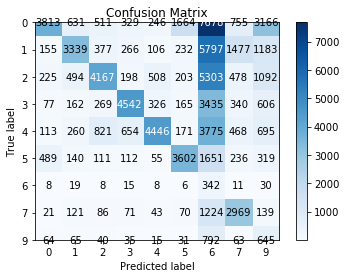

In [104]:
evaluate_features(test_sv, y_test, nb_sv)

### Linear Regression

In [105]:
linr_sv = linear_model.LinearRegression(n_jobs = -1)
%time linr_sv.fit(train_sv, y_train.astype(int))

Wall time: 420 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [106]:
%time linr_score_test_sv = linr_sv.score(test_sv, y_test.astype(int))
linr_score_test_sv*100

Wall time: 10 ms


-7.69069888596543

We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [107]:
lr_sv = linear_model.LogisticRegression(C=5.0, penalty='l2', solver = 'newton-cg', n_jobs=-1)
%time lr_sv.fit(train_sv, y_train)

C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 44.1 s


LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
%time lr_score_test_sv = lr_sv.score(test_sv, y_test.astype(int))
lr_score_test_sv*100

Wall time: 25.9 ms


32.820570967823215

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.8s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished


Log loss: 1.125694547338805
Accuracy: 0.618023534154761


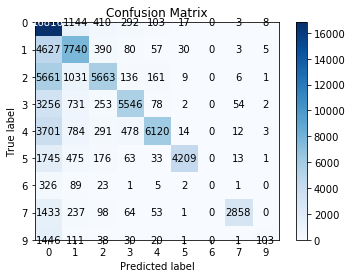

In [109]:
evaluate_features(test_sv, y_test, lr_sv)

### Support Vector Machine
Even at low dimension this takes a lot of time to run.

In [110]:
# clf_sv = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf_sv.fit(train_sv, y_train.astype(int))

In [111]:
# %time clf_score_sv = clf_sv.score(test_sv, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score_sv)

### Random Forest

In [112]:
rf_sv = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

%time rf_sv.fit(train_sv, y_train.astype(int))

Wall time: 1min 36s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [113]:
%time rf_score_sv = rf_sv.score(test_sv, y_test.astype(int))
print("RF accuracy on test:\t %f" % rf_score_sv)

Wall time: 757 ms
RF accuracy on test:	 0.334858


We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Log loss: 1.3095618981969774
Accuracy: 0.5370146395545141


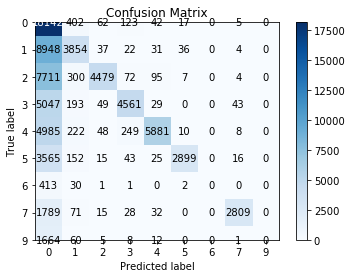

In [114]:
evaluate_features(test_sv, y_test, rf_sv)